In [3]:
from pl_modules.diffusers_vae_module import WeightedSSIMKspaceAutoencoder, WeightedSSIMKspaceAutoencoderKL, KspaceAutoencoder, KspaceAutoencoderKL
from pl_modules.unet_module import UNet
from pathlib import Path

def extract_between_first_two_slashes(path: str) -> str:
    """
    Extracts the substring between the first and second '/' in a given string.
    
    Example:
        "UNet/77iwp3bt/checkpoints/epoch=99-step=6000.ckpt" -> "77iwp3bt"
    """
    parts = path.split('/')
    if len(parts) < 3:
        raise ValueError("Input string must contain at least two '/' characters")
    return parts[0],parts[1]

def load_model(model_type: str, ckpt_path: Path, undersampling: bool = False):
    if model_type == "UNet":
        model = UNet.load_from_checkpoint(ckpt_path, undersampling=undersampling, strict=False)
    elif model_type =="KspaceAutoencoder":
        model = KspaceAutoencoder.load_from_checkpoint(ckpt_path, undersampling=undersampling, strict=False)
    elif model_type == "WeightedSSIMKspaceAutoencoder":
        model = WeightedSSIMKspaceAutoencoder.load_from_checkpoint(ckpt_path, undersampling=undersampling, strict=False)
    elif model_type == "KspaceAutoencoderKL":
        model = KspaceAutoencoderKL.load_from_checkpoint(ckpt_path, undersampling=undersampling, strict=False)
    elif model_type == "WeightedSSIMKspaceAutoencoderKL":
        model = WeightedSSIMKspaceAutoencoderKL.load_from_checkpoint(ckpt_path, undersampling=undersampling, strict=False)
    else:
        print("No model found")
        raise ValueError("Invalid input provided")
    
    for p in model.parameters():
        p.requires_grad = False
    
    return model

/home/atuin/b180dc/b180dc46/software/private/conda/envs/kdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
ae_ckpts = [
    "KspaceAutoencoder/1477y5so/checkpoints/KspaceAutoencoder-epoch=32.ckpt", 
    "KspaceAutoencoder/efxwfisc/checkpoints/KspaceAutoencoder-epoch=30.ckpt",
    "KspaceAutoencoder/emkjiw54/checkpoints/KspaceAutoencoder-epoch=29.ckpt"]

sae_ckpts = [
    "WeightedSSIMKspaceAutoencoder/8fvbciuk/checkpoints/WeightedSSIMKspaceAutoencoder-epoch=36.ckpt",
    "WeightedSSIMKspaceAutoencoder/malxq0c1/checkpoints/WeightedSSIMKspaceAutoencoder-epoch=13.ckpt",
    "WeightedSSIMKspaceAutoencoder/yxusji86/checkpoints/WeightedSSIMKspaceAutoencoder-epoch=42.ckpt"
]

vae_ckpts = [
    # "KspaceAutoencoderKL/5xovkqf3/checkpoints/KspaceAutoencoderKL-epoch=00.ckpt",
    "KspaceAutoencoderKL/tnyvxepp/checkpoints/KspaceAutoencoderKL-epoch=02.ckpt",
    # "KspaceAutoencoderKL/vuwzswa8/checkpoints/KspaceAutoencoderKL-epoch=25.ckpt"
]

unet_ckpts = [
    "UNet/77iw30sm/checkpoints/UNet-epoch=79.ckpt",
    "UNet/hdzt9rut/checkpoints/UNet-epoch=09.ckpt",
    "UNet/pcoj4e7y/checkpoints/UNet-epoch=21.ckpt"
]

svae_ckpts = [
    "WeightedSSIMKspaceAutoencoderKL/9fkym2v7/checkpoints/WeightedSSIMKspaceAutoencoderKL-epoch=65.ckpt",
    "WeightedSSIMKspaceAutoencoderKL/b63zsecl/checkpoints/WeightedSSIMKspaceAutoencoderKL-epoch=66.ckpt",
    # "WeightedSSIMKspaceAutoencoderKL/gmnryi4i/checkpoints/WeightedSSIMKspaceAutoencoderKL-epoch=74.ckpt",
    # "WeightedSSIMKspaceAutoencoderKL/qu0dvox4/checkpoints/WeightedSSIMKspaceAutoencoderKL-epoch=55.ckpt",
    "WeightedSSIMKspaceAutoencoderKL/rojsgaoo/checkpoints/WeightedSSIMKspaceAutoencoderKL-epoch=34.ckpt",
    "WeightedSSIMKspaceAutoencoderKL/utr2dmhv/checkpoints/WeightedSSIMKspaceAutoencoderKL-epoch=31.ckpt"
]

In [26]:
from fastmri.data.mri_data import SliceDataset
from modules.transforms import KspaceUNetDataTransform
from fastmri.data.subsample import create_mask_for_mask_type
import torch
import matplotlib.pyplot as plt
acc = 4
ckpts = vae_ckpts
undersampling = False
mask_func = create_mask_for_mask_type(
    mask_type_str="equispaced",
    center_fractions=[0.08],
    accelerations=[acc]
)
transform = KspaceUNetDataTransform(mask_func=mask_func)
dataset = SliceDataset(
    root=Path("/home/janus/iwbi-cip-datasets/shared/fastMRI/knee/singlecoil_val"),
    challenge="singlecoil",
    transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=2)

for ckpt in ckpts:
    model_type, id = extract_between_first_two_slashes(ckpt)
    model = load_model(model_type=model_type, ckpt_path=ckpt, undersampling=undersampling)

    if undersampling:
        output_dir = Path("evaluation") / model_type / id / "images" / str(acc)
    else:
        output_dir = Path("evaluation") / model_type / id / "images" / "full"
    output_dir.mkdir(parents=True, exist_ok=True)
    for i, batch in enumerate(dataloader):
        if i > 50:
            break
        if batch.fname[0] == "file1000000.h5":
            if batch.slice_num.item() == 21 or batch.slice_num.item() == 27:
                output = model.test_step(batch, None)["reconstructions"]
                target = batch.target
                target = target / torch.max(target)
                output = output / torch.max(output)
                error = torch.abs(target - output)
                error = error / torch.max(error)
                plt.imshow(output.squeeze(0), cmap="gray")    
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(output_dir / (str(batch.fname[0][:-3]) +  "_" + str(batch.slice_num.item()) + ".png") , bbox_inches="tight", dpi=1000, pad_inches=0)
                plt.close()
                plt.imshow(target.squeeze(0), cmap="gray")    
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(output_dir / ("target_" + str(batch.fname[0][:-3]) +  "_" + str(batch.slice_num.item()) + ".png") , bbox_inches="tight", dpi=1000, pad_inches=0)
                plt.close()
                plt.imshow(error.squeeze(0), cmap="inferno")  
                # plt.colorbar()  
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(output_dir / ("error_" + str(batch.fname[0][:-3]) +  "_" + str(batch.slice_num.item()) + ".png") , bbox_inches="tight", dpi=1000, pad_inches=0, transparent=True)
                plt.close()

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Undersampling: False
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Channels:  (128, 128, 256, 512)


Z shape:  torch.Size([1, 16, 80, 48])


In [13]:
from modules.transforms import kspace_to_mri
for i, batch in enumerate(dataloader):
        if i > 50:
            break
        if batch.fname[0] == "file1000000.h5":
            if batch.slice_num.item() == 21 or batch.slice_num.item() == 27:
                masked_kspace = batch.masked_kspace
                target = batch.target
                masked = kspace_to_mri(masked_kspace)
                masked = masked / torch.max(masked)
                target = target / torch.max(target)
                error = torch.abs(target - masked)
                error = error / torch.max(error)

                plt.imshow(masked.squeeze(0), cmap="gray")  
                # plt.colorbar()  
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(("masked_" + str(batch.fname[0][:-3]) +  "_" + str(batch.slice_num.item()) + ".png") , bbox_inches="tight", dpi=1000, pad_inches=0, transparent=True)
                plt.close()

                plt.imshow(error.squeeze(0), cmap="inferno")  
                # plt.colorbar()  
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(("masked_error_" + str(batch.fname[0][:-3]) +  "_" + str(batch.slice_num.item()) + ".png") , bbox_inches="tight", dpi=1000, pad_inches=0, transparent=True)
                plt.close()


In [9]:
output.shape

torch.Size([1, 320, 320])

In [4]:
from fastmri.pl_modules import FastMriDataModule
from fastmri.data.subsample import create_mask_for_mask_type
from pathlib import Path
from modules.transforms import KspaceUNetDataTransform

config = {
    "mask_type": "equispaced",
    "center_fractions": [0.04],
    "accelerations": [8],
}

mask_func = create_mask_for_mask_type(
    config["mask_type"], config["center_fractions"], config["accelerations"]
)
# use random masks for train transform, fixed masks for val transform
train_transform = KspaceUNetDataTransform(mask_func=mask_func, use_seed=False)
val_transform = KspaceUNetDataTransform(mask_func=mask_func)
test_transform = KspaceUNetDataTransform()
data_module = FastMriDataModule(
    data_path=Path("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped"),
    challenge="singlecoil",
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    combine_train_val=False,
    test_split="test",
    sample_rate=None,
    batch_size=1,
    num_workers=4,
    distributed_sampler=False,
    use_dataset_cache_file=True
)
dm = FastMriDataModule(
    data_path=Path("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped"),
    challenge="singlecoil",
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    combine_train_val=False,
    test_split="test",
    sample_rate=None,
    batch_size=4,
    num_workers=4,
    distributed_sampler=False,
    use_dataset_cache_file=True
)

In [22]:
from typing import Optional, Tuple
import torch
import warnings
import torch.nn.functional as F

class LatentDDPMPipeline(diffusers.DDPMPipeline):
    def __init__(self, unet, scheduler, sample_size: Tuple[int, int], num_inference_timesteps: int = 1000):
        super().__init__(unet, scheduler)
        self.sample_size = sample_size
        self.num_inference_steps = num_inference_timesteps
        # set step values
        self.scheduler.set_timesteps(self.num_inference_steps)
    
    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        conditional_samples: Optional[torch.Tensor] = None,
        diffusion_steps: int = 100,
        generator: Optional[torch.Generator] = None,
        **kwargs,
    ) ->  Tuple:
        r"""
        Args:
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `nd.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipeline_utils.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipeline_utils.ImagePipelineOutput`] or `tuple`: [`~pipelines.utils.ImagePipelineOutput`] if
            `return_dict` is True, otherwise a `tuple. When returning a tuple, the first element is a list with the
            generated images.
        """
        if "torch_device" in kwargs:
            device = kwargs.pop("torch_device")
            warnings.warn(
                "`torch_device` is deprecated as an input argument to `__call__` and will be removed in v0.3.0."
                " Consider using `pipe.to(torch_device)` instead."
            )

            # Set device as before (to be removed in 0.3.0)
            if device is None:
                device = "cuda" if torch.cuda.is_available() else "cpu"
            self.to(device)
        if conditional_samples is not None:
            noise = torch.randn_like(conditional_samples)
            steps = torch.randint(diffusion_steps, (conditional_samples.size(0),), device=self.device)
            image = self.scheduler.add_noise(conditional_samples, noise, steps)

        else:
            # Sample gaussian noise to begin loop
            image = torch.randn(
                (batch_size, self.unet.config.in_channels, *self.sample_size),
                generator=generator,
            )
        image = image.to(self.device)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t).sample

            # 2. compute previous image: x_t -> t_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        # image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu()
        return image
    
    

In [23]:
pipe = LatentDDPMPipeline(model.model, scheduler, (80, 48), 1000)

In [24]:
import torch 
from modules.transforms import kspace_to_mri
import matplotlib.pyplot as plt
with torch.inference_mode():
    latents = pipe(
        batch_size=1,
    )
    unpadded = latents[:, :, :, :46]
    reconstructions = first_stage.decode(unpadded.to("cuda"))
img = kspace_to_mri(reconstructions.permute(0, 2, 3, 1).contiguous())


100%|██████████| 1000/1000 [00:27<00:00, 36.59it/s]


In [26]:
img = img / img.max()

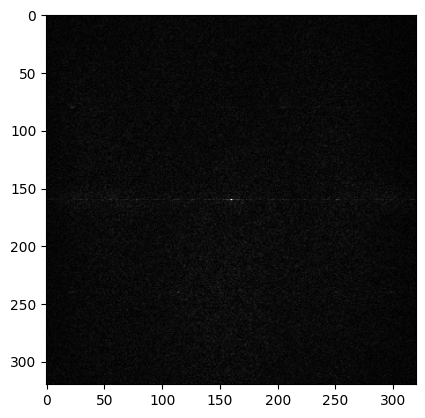

In [27]:
plt.imshow(img.squeeze(0).cpu(), "gray")
plt.show()

In [13]:
from pl_modules.data_module import LDMLatentDataModule
from pathlib import Path
dm = LDMLatentDataModule(
    Path("latent_data/new"),
    "singlecoil",
    3,
    4
)
dm.setup("fit")

In [14]:
dl = iter(dm.train_dataloader())

torch.Size([3, 16, 80, 46])
('file1000048.h5', 'file1000213.h5', 'file1001723.h5')
tensor([35, 16, 34])


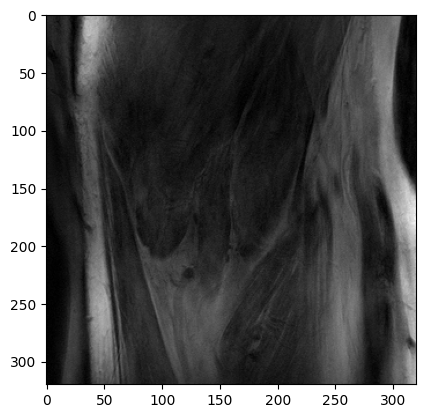

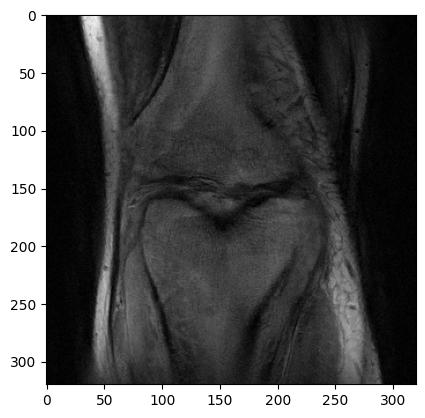

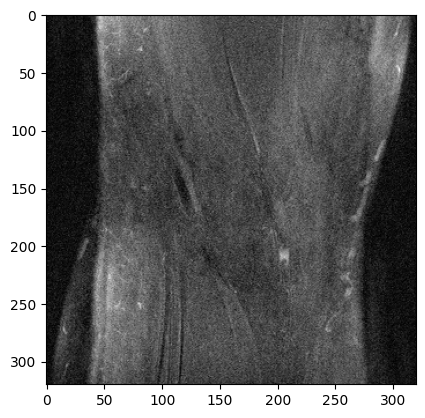

In [15]:
from modules.transforms import norm, unnorm, kspace_to_mri
import torch
first_stage.eval()
batch = next(dl)
print(batch.full_latent_tensor.shape)
print(batch.fname)
print(batch.slice_num)
with torch.inference_mode():
    reconstructions = first_stage.decode(batch.full_latent_tensor.cuda())
img = kspace_to_mri(reconstructions.permute(0, 2, 3, 1).contiguous())
import matplotlib.pyplot as plt

plt.imshow(img[0].cpu(), cmap="gray")
plt.show()
plt.imshow(img[1].cpu(), cmap="gray")
plt.show()
plt.imshow(img[2].cpu(), cmap="gray")
plt.show()

In [28]:
import h5py
hf = h5py.File("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped/singlecoil_train/file1000313.h5")

In [29]:
from fastmri.data.transforms import to_tensor
input, mean, std = norm(to_tensor(hf["kspace"][26]).unsqueeze(0).permute(0, 3, 1, 2).contiguous())

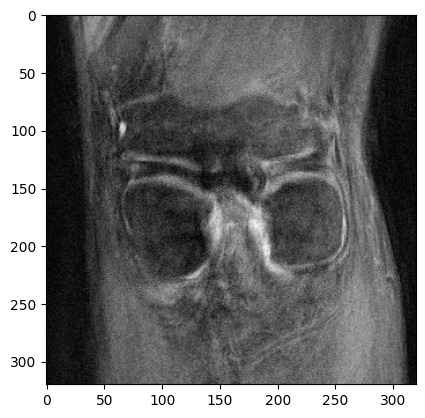

In [30]:
with torch.inference_mode():
    lst = first_stage.encode(input.cuda())
    output = first_stage.decode(lst)
output = unnorm(output, mean.cuda(), std.cuda())
img = kspace_to_mri(output.permute(0, 2, 3, 1).contiguous())

import matplotlib.pyplot as plt

plt.imshow(img.squeeze(0).cpu(), "gray")
plt.show()

100%|██████████| 1000/1000 [00:22<00:00, 44.03it/s]


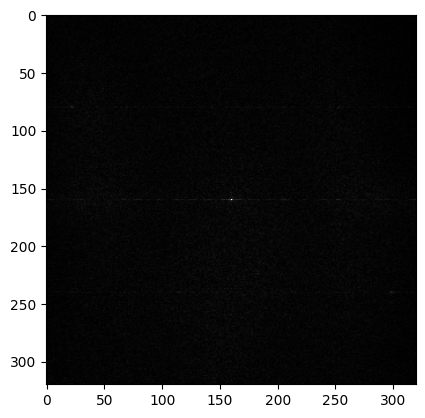

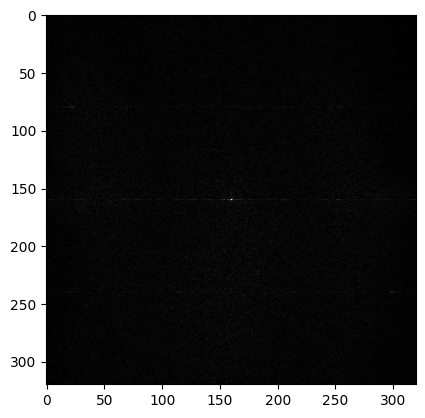

In [44]:
conditional_pipe = LatentDDPMPipeline(model.model, scheduler, (80,48), 1000)
z = F.pad(lst, (0, 2))
z, z_mean, z_std = norm(z)
with torch.inference_mode():
    z = conditional_pipe(1, z, 200)
final_latens = unnorm(z.cpu(), z_mean.cpu(), z_std.cpu())
unpadded = z[:, :, :, :46]
with torch.inference_mode():
    reconstructions = first_stage.decode(unpadded.to("cuda"))
reconstructions = unnorm(reconstructions, mean.cuda(), std.cuda())
img = kspace_to_mri(reconstructions.permute(0, 2, 3, 1).contiguous())

image = img
import matplotlib.pyplot as plt
image = (image / 2 + 0.5).clamp(0, 1)

plt.imshow(img.squeeze(0).cpu(), "gray")
plt.show()
plt.imshow(image.squeeze(0).cpu(), "gray")
plt.show()